In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# DWave Credentials
dwave_solver = os.getenv('DWAVE_API_SOLVER')
api_key = os.getenv('DWAVE_API_TOKEN')

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

import dwave_networkx as dnx

### Use NetworkX graphic package to create a signed network
import networkx as nx

# Select a D-Wave system and handle mapping from problem graph to sampler graph
sampler = EmbeddingComposite(DWaveSampler(solver=dwave_solver, token=api_key))

In [2]:
# Helper Functions

def make_graph(corr_mat, node_labels, graph_type):

    G = nx.Graph()
    G.add_nodes_from(node_labels)
    dim = corr_mat.shape[0]

    if not dim == len(node_labels):
        raise ValueError('number node labels not = corr matrix dimensions')

    if graph_type=='signed':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] < 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=-1)
                elif corr_mat[i,j] > 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=1)
    
    if graph_type=='corr':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] != 0.000:
                    G.add_edge(node_labels[i], node_labels[j])
    
    if graph_type=='uncorr':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] == 0.000:
                    G.add_edge(node_labels[i], node_labels[j])
    
    density = (2*G.number_of_edges())/(G.number_of_nodes()*(G.number_of_nodes() - 1))
                
    return G, density

def get_max_deg(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

    return max(degree_sequence)

def clique_size(clique):
    return len(clique)

In [3]:
# Import data

dataset = 'asset_class' # values: 'asset_class','ftse','sectors','sp100'

corr_tensor = np.load('../Data/%s/%s_corr.npy' % (dataset, dataset))
dates = np.load('../Data/%s/%s_dates.npy' % (dataset, dataset))
nodes = np.load('../Data/%s/%s_nodes.npy' % (dataset, dataset))
nodes_descr = np.load('../Data/%s/%s_nodes_descr.npy' % (dataset, dataset))

num_examples = corr_tensor.shape[0]
dim = corr_tensor.shape[1]

In [4]:
print("num examples: %d, matrix dim: %d" % (num_examples, dim))

num examples: 120, matrix dim: 19


In [8]:
# Plot graph density for each threshold. 
thresh_array = []
density_distr = []

for i in np.arange(0.1, 1, 0.1):
    density_array = []
    for j in range(1, int(num_examples/3)):
        corr_mat = corr_tensor[j*3, :, :].copy()
        corr_mat[(corr_mat > -1*i) & (corr_mat < i)] = 0
        G, density = make_graph(corr_mat, nodes, 'corr')
        
        density_array.append(density)
    
    density_distr.append(density_array)

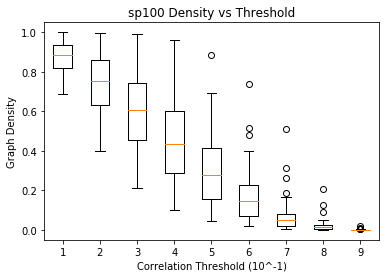

In [9]:
plt.boxplot(density_distr)
plt.ylabel("Graph Density")
plt.xlabel("Correlation Threshold (10^-1)")
plt.title("%s Density vs Threshold" % (dataset))
plt.show()

In [35]:
# Test to see if DW comp. is working
corr_mat = corr_tensor[int(num_examples/2), :, :].copy()
        
corr_mat[(corr_mat > -1*0.7) & (corr_mat < 0.7)] = 0
G, density = make_graph(corr_mat, nodes, 'corr')

In [36]:
density

0.13450292397660818

/Users/angadkalra/Projects/dwave_ocean/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


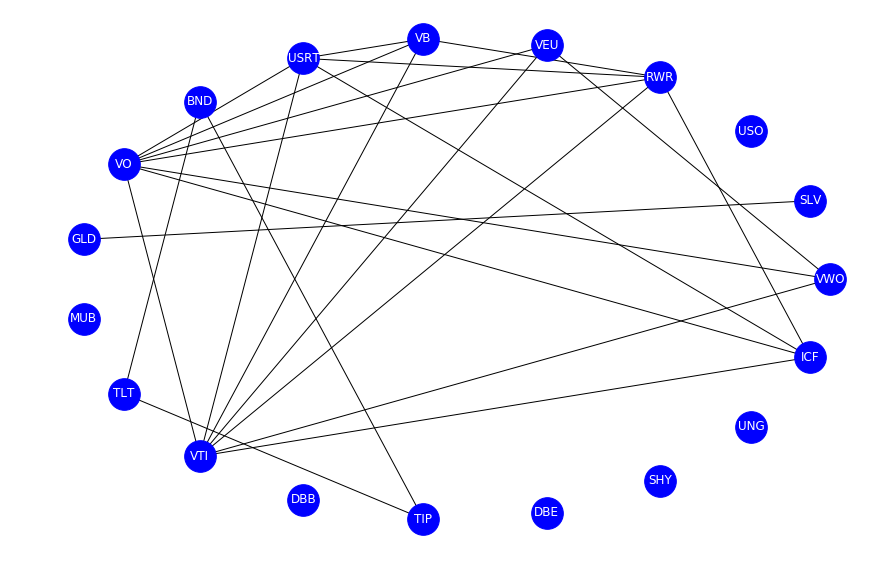

In [37]:
# Draw graph
fig,ax = plt.subplots(figsize=(15,10))
nx.draw_shell(G, ax=ax, with_labels=True, node_size=1000, node_color="blue", font_color="white")
fig.savefig('../ReportFiguresPlots/MaxClique/GraphVisual/%s_low_density.png'%(dataset))

In [32]:
max_clique = dnx.maximum_clique(G, sampler)
valid_soln = dnx.is_clique(G, max_clique)

In [36]:
max_clique

['VWO', 'USRT', 'VB', 'VO', 'VTI', 'VEU']

In [33]:
assert len(max_clique) > 0

In [34]:
dnx.is_clique(G, max_clique)

True

In [35]:
clique_size(max_clique)

6

/Users/angadkalra/Projects/dwave_ocean/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


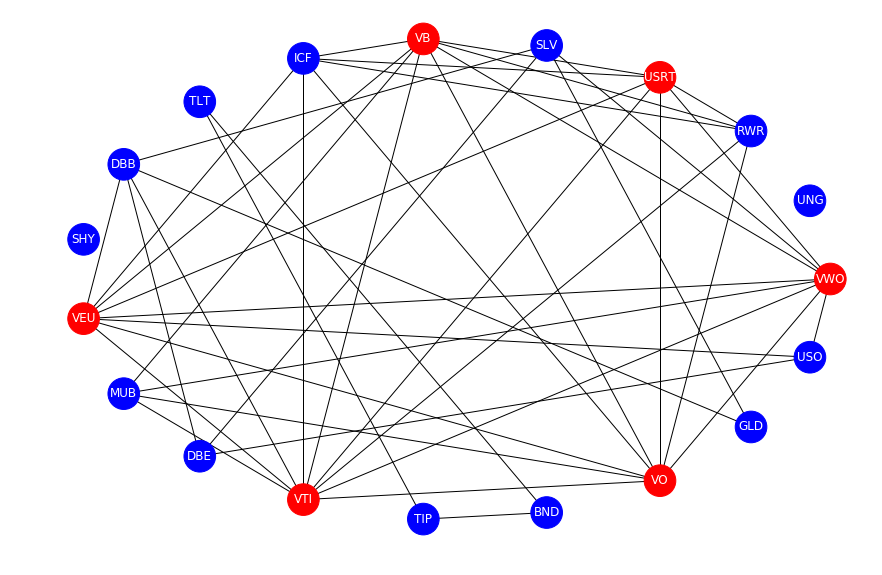

In [37]:
# Draw solution
node_coloring = []
for node in G.nodes():
    if node in max_clique:
        node_coloring.append("red")
    else:
        node_coloring.append("blue")
        
fig,ax = plt.subplots(figsize=(15,10))
nx.draw_shell(G, ax=ax, with_labels=True, node_size=1000, 
                 node_color=node_coloring, font_color="white")
fig.savefig('../ReportFiguresPlots/MaxClique/GraphVisual/%s_after.png'%(dataset))

In [ ]:
# Create graph for each month and calculate max clique. 

clique_array = []
valid_clique_array = []
clique_size_array = []
date_array = []
density_array = []
threshold_array = []

count = 0
for i in np.arange(0.1, 0.6, 0.1):
    for j in range(1, int(num_examples/5)):
        
        corr_mat = corr_tensor[j*5, :, :].copy()
        corr_mat[(corr_mat > -1*i) & (corr_mat < i)] = 0
        
        G, density = make_graph(corr_mat, nodes, 'corr')
        
        count += 1
        if count % 10 == 0: print("count: %d" % (count))
        
        try:
            opt_clique = dnx.maximum_clique(G, sampler)
            max_clique_size = len(opt_clique)
            valid_clique = dnx.is_clique(G, opt_clique)
            
            for k in range(3):
                max_clique = dnx.maximum_clique(G, sampler)
                clique_size = len(max_clique)
                valid_clique = dnx.is_clique(G, max_clique)
                
                if valid_clique and clique_size > max_clique_size:
                    opt_clique = max_clique
                    max_clique_size = clique_size
                
        except Exception as err:
            print(err)
            print("No embedding found for threshold %f and matrix %d" % (i, j*5))
        else:
            clique_array.append(opt_clique)
            valid_clique_array.append(valid_clique)
            clique_size_array.append(max_clique_size)
            
            threshold_array.append(i)
            density_array.append(density)
            date_array.append(dates[j*5])

In [90]:
assert len(clique_array) == len(date_array) == len(density_array) == len(threshold_array) == len(clique_size_array)

In [91]:
len(clique_array)

161

In [92]:
# Create Pandas DataFrame for quantum results
pd.DataFrame(data={"date": date_array, "threshold": threshold_array, "density": density_array,
                "max_clique": clique_array, "clique_size": clique_size_array, 
                "valid_clique": valid_clique_array}).to_csv("maxclique_quant_%s_res.csv" % (dataset))

In [93]:
# Run classical max clique algm on the matrices that ran successfully above
from networkx.algorithms.approximation.clique import max_clique as class_max_clique

clique_array = []
valid_clique_array = []
clique_size_array = []
density_array = []

for i in range(len(threshold_array)):
    
    # get threshold and matrix idx 
    thresh = threshold_array[i]
    idx = dates.tolist().index(date_array[i])
    
    corr_mat = corr_tensor[idx, :, :].copy()
    corr_mat[(corr_mat > -1*thresh) & (corr_mat < thresh)] = 0

    G, density = make_graph(corr_mat, nodes, 'corr')

    try:
        max_clique = class_max_clique(G)
        valid_clique = dnx.is_clique(G, max_clique)
    except Exception as err:
        print(err)
        print("Error on matrix %d with threshold %f" % (j*5, i))
    else:
        
        clique_array.append(max_clique)
        valid_clique_array.append(valid_clique)
        clique_size_array.append(len(max_clique))

        density_array.append(density)


In [94]:
assert len(clique_array) == len(date_array) == len(density_array) == len(threshold_array) == len(clique_size_array)

In [95]:
len(clique_array)

161

In [96]:
# Create Pandas DataFrame for class results
pd.DataFrame(data={"date": date_array, "threshold": threshold_array, "density": density_array,
                "max_clique": clique_array, "clique_size": clique_size_array, 
                "valid_clique": valid_clique_array}).to_csv("maxclique_class_%s_res.csv" % (dataset))